# Imports

In [1]:
import requests as rq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
import datetime as dt
import time
import pickle

In [2]:
def save_pickle(file_name, object):
    # Open the file in binary write mode
    with open(file_name, 'wb') as file:
        # Use pickle.dump() to export the dictionary to the file
        pickle.dump(object, file)

    print("Dictionary exported successfully.")

def load_pickle(file_name):
    # Importing the dictionary back from the pickle file
    with open(file_name, 'rb') as file:
        loaded_dict = pickle.load(file)

    #print("Dictionary imported successfully.")
    
    return loaded_dict

def date_reverse(date):
    return pd.to_datetime(date, format="%y%m%d").date()

import calendar
import datetime

def get_next_third_friday(year, month, day):
    specified_date = datetime.date(year, month, day)
    
    # Get the first day of the month
    first_day = datetime.date(year, month, 1)
    
    # Find the first Friday of the month
    first_friday = first_day + datetime.timedelta((calendar.FRIDAY - first_day.weekday()) % 7)
    
    # Calculate the third Friday
    third_friday = first_friday + datetime.timedelta(weeks=2)
    
    # Check if the specified day is already the third Friday
    if specified_date == third_friday:
        return f'{str(year)[-2:]}{month:02d}{day:02d}'
    
    # If the specified day is after the third Friday, move to the next month
    if specified_date > third_friday:
        if month == 12:
            year += 1
            month = 1
        else:
            month += 1
    
    # Recalculate the third Friday for the updated month.
    _, days_in_month = calendar.monthrange(year, month)
    first_day = datetime.date(year, month, 1)
    first_friday = first_day + datetime.timedelta((calendar.FRIDAY - first_day.weekday()) % 7)
    third_friday = first_friday + datetime.timedelta(weeks=2)
    
    # Format the output as YYMMDD.
    return f'{str(third_friday.year)[-2:]}{third_friday.month:02d}{third_friday.day:02d}'


def get_strike(strike):
    return (8 - len(str(strike*1000)))*"0" + str(strike*1000)

def res_parser(df):
    temp = pd.DataFrame(df["results"])
    temp["t"] = pd.to_datetime(temp["t"], unit="ms")
    temp.set_index("t", inplace=True, drop=True)
    return temp

def num_wrong(dict, length):
    x = 0
    for i in range(length):
        if dict[i]["data"] is None:
            x += 1
    print(x)

# Tickers

In [7]:
api_key = "xyLM6NEKxAw3177JxN_307ERYuLo27i8"
ticker = ""
limit = 1000
search = "Cboe S&P 500"
exchange = ""
res = rq.get(f"https://api.polygon.io/v3/reference/tickers?market=indices&active=true&limit={limit}&search={search}&exchange={exchange}&apiKey={api_key}").json()


In [8]:
ticker_df = pd.DataFrame(res["results"])
ticker_df.to_excel("tickers_sp.xlsx")

# Options Data

In [ ]:
# Single use searcher.
# SPXW??
# 220415 ——> 220414
"""{'strike': '00170000',
 'exp_date': '220415',
 'start_date': '2022-03-18',
 'end_date': '2022-04-15',
 'data': None}"""

api_key = "xyLM6NEKxAw3177JxN_307ERYuLo27i8"
#exp_date = get_next_third_friday(2022, 3, 18)
exp_date = 220414
strike = get_strike(170)
ticker = f"O:AAPL{exp_date}C{strike}"
start_date = "2022-04-01"
end_date = "2022-04-14"
time_multi = 1
time_frame = "hour"
limit = 50_000
res = rq.get(f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/{time_multi}/{time_frame}/{start_date}/{end_date}?adjusted=true&sort=asc&limit={limit}&apiKey={api_key}").json()

res

In [186]:
# Options iterator.
#for i in range(len(sdf)):
for i in range(0,1):
    row = sdf.iloc[i]
    api_key = "xyLM6NEKxAw3177JxN_307ERYuLo27i8"
    exp_date = row[1]
    #strike = get_strike(int(row[0]))
    strike = get_strike(12250)
    ticker = f"O:NDX{exp_date}C{strike}"
    start_date = str(row.name.date())
    end_date = str(pd.to_datetime(row[1], format="%y%m%d").date())
    time_multi = 30
    time_frame = "minute"
    res = rq.get(f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/{time_multi}/{time_frame}/{start_date}/{end_date}?adjusted=true&sort=asc&limit=120&apiKey={api_key}").json()

len(res_parser(res))

/tmp/ipykernel_1638/1211483021.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  exp_date = row[1]
/tmp/ipykernel_1638/1211483021.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  end_date = str(pd.to_datetime(row[1], format="%y%m%d").date())


30

# Indices Data

In [ ]:
# Download price data.
end_date = "2024-03-01"
start_date = "2022-03-10" 
api_key = "xyLM6NEKxAw3177JxN_307ERYuLo27i8"
ticker = f"AAPL"
time_multi = 30
time_frame = "minute"
limit = 50_000
df_main = pd.DataFrame()

while pd.to_datetime(start_date) < pd.to_datetime(end_date):
    res = rq.get(f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/{time_multi}/{time_frame}/{start_date}/{end_date}?adjusted=true&sort=asc&limit={limit}&apiKey={api_key}").json()

    temp_df = pd.DataFrame(res["results"])
    temp_df["t"] = pd.to_datetime(temp_df["t"], unit="ms")

    temp_df.set_index("t", inplace=True, drop=True)
    df_main = pd.concat([df_main, temp_df])

    start_date = str(df_main.index.max().date())
    print(start_date)
    time.sleep(15)


df_main.drop_duplicates(inplace=True)
df_main.to_csv("AAPL_data_30m.csv")

In [5]:
# Import the data from file.
df_main = pd.read_csv("AAPL_data_30m.csv")
df_main.set_index(pd.DatetimeIndex(df_main["t"]), inplace=True)
df_main = df_main.drop(columns=[df_main.columns[0], "t"])

df = df_main.copy()

### Constant Addition to Price

In [6]:
# Resample weekly and back into 30min data, with each week having the weekly avg std.
time_frame = "30min"
df_w = df_main.resample("w").std()
df_w = df_w.resample(time_frame).bfill()

dates = pd.date_range(start=df_w.index[0] - pd.Timedelta(days=7), end=df_w.index[0], freq=time_frame)

time_range_data = {
    'c': [df_w["c"].iloc[0]]*len(dates),
    't': dates
}
first_w = pd.DataFrame(time_range_data).set_index("t")
df_w = pd.concat([first_w, df_w])

df_w = df_w.loc[df.index]

Code which gets the next expiry date for a given timestamp in the dataset.

In [7]:
# Copy index from main df and then create a column w corresponding opt expiry date.
df_expiry = pd.DataFrame(df.index)
df_expiry["expiry"] = df_expiry["t"].apply(lambda x: get_next_third_friday(x.year, x.month, x.day))
df_expiry.set_index("t", drop=True, inplace=True)
df_expiry.replace("220415", "220414", inplace=True) # replace exchange holidays.

# Convert into necessary format for polygon api and concat to main df.
exp_for_df = pd.to_datetime(df_expiry["expiry"], format="%y%m%d")
df = pd.concat([exp_for_df, df], axis=1)

# Find time until expiry.
df["t_until_exp"] = df["expiry"] - df.index
df["t_until_exp"] = df["t_until_exp"].dt.total_seconds()/(60*60*24)

/tmp/ipykernel_1596/249982283.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [plt.axvline(temp_expiries[i], color="black", linestyle="dashed", alpha=0.7) for i in range(2)]


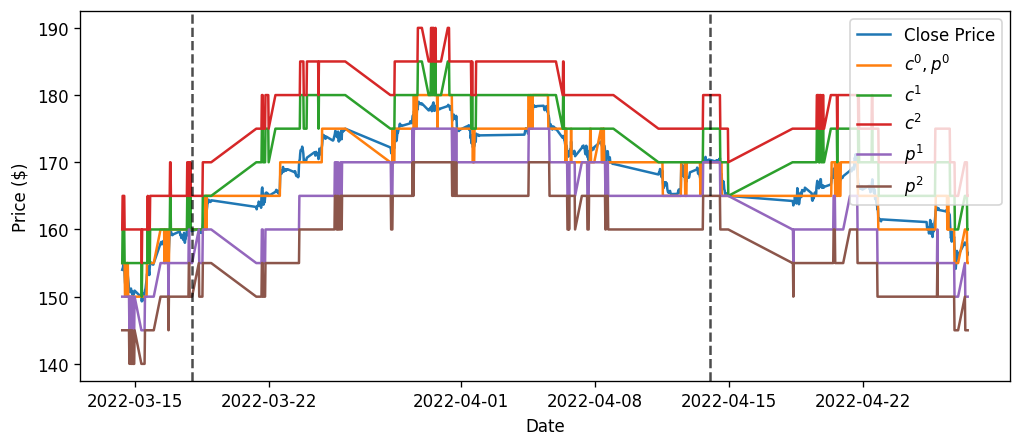

In [28]:
round_to = 5
T = df["t_until_exp"].max()

df["c_0"] = np.round(df["c"]/round_to, 0)*round_to
df["c_1"] = df["c"] + 2*df_w["c"]*(1 - (T - df["t_until_exp"])/T)

df["p_0"] = np.round(df["c"]/round_to, 0)*round_to
df["p_1"] = df["c"] - 2*df_w["c"]*(1 - (T - df["t_until_exp"])/T)

df["c_1_round"] = np.ceil(df["c_1"] / round_to) * round_to
df["c_2_round"] = df["c_1_round"] + 5
df["c_3_round"] = df["c_1_round"] + 10

df["p_1_round"] = np.floor(df["p_1"] / round_to) * round_to
df["p_2_round"] = df["p_1_round"] - 5
df["p_3_round"] = df["p_1_round"] - 10

temp_expiries = df["expiry"].sort_values().drop_duplicates()
x = 1000
plt.figure(figsize=(10,4), dpi=120)
plt.plot(df["c"][:x], label="Close Price")
plt.plot(df["c_0"][:x], label="$c^0, p^0$")
plt.plot(df["c_1_round"][:x], label="$c^1$")
plt.plot(df["c_2_round"][:x],  label="$c^2$")
plt.plot(df["p_1_round"][:x], label="$p^1$")
plt.plot(df["p_2_round"][:x], label="$p^2$")
[plt.axvline(temp_expiries[i], color="black", linestyle="dashed", alpha=0.7) for i in range(2)]
plt.legend(loc="upper right")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.savefig("strike_demo.png", dpi=200)

In [10]:
# New df with the rounded call and put values.
strike_df = df[["c_0", "c_1_round", "c_2_round", "p_0", "p_1_round", "p_2_round"]]

# Combine with expiry date and rename.
strike_df = pd.concat([strike_df, df_expiry["expiry"]], axis=1)
strike_df.rename(columns={"c_1_round": "c_1", "c_2_round": "c_2", "p_1_round": "p_1", "p_2_round": "p_2"}, inplace=True)
episode_list = strike_df["expiry"].drop_duplicates()
#strike_df.to_csv("strike_df_30.csv")

# Drop dupes to get the first instance of each strike/exp combo.
call_strikes_duped = [strike_df[[f"c_{i}", "expiry"]].drop_duplicates().rename(columns={f"c_{i}": "c"}) for i in range(0,3)]
call_strikes = pd.concat([call_strikes_duped[0], call_strikes_duped[1], call_strikes_duped[2]], axis=0).sort_index().drop_duplicates()

put_strikes_duped = [strike_df[[f"p_{i}", "expiry"]].drop_duplicates().rename(columns={f"p_{i}": "p"}) for i in range(0,3)]
put_strikes = pd.concat([put_strikes_duped[0], put_strikes_duped[1], put_strikes_duped[2]], axis=0).sort_index().drop_duplicates()

In [ ]:
# Options iterator.
option = "C"
data_dict = {}
strikes = call_strikes

for i in range(len(strikes)):
    try:
        row = strikes.iloc[i]
        api_key = "xyLM6NEKxAw3177JxN_307ERYuLo27i8"
        exp_date = row[1]
        strike = get_strike(int(row[0]))
        #strike = get_strike(155)
        ticker = f"O:AAPL{exp_date}{option}{strike}"
        start_date = str(row.name.date())
        end_date = str(pd.to_datetime(row[1], format="%y%m%d").date())
        time_multi = 30
        time_frame = "minute"
        limit = 50_000
        res = rq.get(f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/{time_multi}/{time_frame}/{start_date}/{end_date}?adjusted=true&sort=asc&limit={limit}&apiKey={api_key}").json()

        print(strike, exp_date, start_date, end_date)

        opt_data = res_parser(res)

        i = f"{exp_date}_{int(strike)/1000}"
        data_dict.update({i: {"strike": strike, "exp_date": exp_date, "start_date": start_date, "end_date": end_date, "data": opt_data}})
        time.sleep(15)
    
    except:
        i = f"{exp_date}_{int(strike)/1000}"
        data_dict.update({i: {"strike": strike, "exp_date": exp_date, "start_date": start_date, "end_date": end_date, "data": None}})
        time.sleep(15)

In [24]:
#save_pickle("put_data_dict.pkl", data_dict)
save_pickle("call_data_dict.pkl", data_dict)

Dictionary exported successfully.


# Post-Download Engineering

In [11]:
start_time = pd.to_datetime('14:30').time()
end_time = pd.to_datetime('20:45').time()
#trimmed_df = df.loc[(df.index.time >= start_time) & (df.index.time <= end_time)]
#trimmed_df.to_csv("trimmed_df_30m.csv")

df = pd.read_csv("trimmed_df_30m.csv")
df.set_index(pd.to_datetime(df["t"]), inplace=True)
df = df[["v", "vw", "o", "c", "h", "l", "n", "t_until_exp"]]
df.rename(columns={i: "s_"+i for i in df.columns}, inplace=True)

c_data = load_pickle("call_data_dict.pkl")
p_data = load_pickle("put_data_dict.pkl")

Dictionary imported successfully.
Dictionary imported successfully.


What we are doing here is iterating over each episode in the put and call data dictionaries, then we are slicing the equity dataset to only include the full range of available data between 14:30 - 20:45. The initial concat is actually against c1 given this has the most values. The rest are concated to merge indices and then missing data is filled forwad.

In [ ]:
# dict_keys(['strike', 'exp_date', 'start_date', 'end_date', 'data'])
# Have to do this for both call and put data manually.
c_data = load_pickle("call_data_dict.pkl")
p_data = load_pickle("put_data_dict.pkl")

def backfill_opt_data(data):
    start_time = pd.to_datetime('14:30').time()
    end_time = pd.to_datetime('20:45').time()

    for key in list(data.keys()):
        start = pd.to_datetime(data[key]["start_date"])
        if pd.to_datetime(data[key]["start_date"]) < pd.Timestamp(year=2022, month=3, day=9):
            start = pd.Timestamp(year=2022, month=3, day=9)

        end = pd.to_datetime(data[key]["end_date"])+pd.Timedelta(days=1)
        dr = pd.date_range(start=start, end=end, freq="15min")
        dr_business = pd.date_range(start=start, end=end, freq="B")
        condition = (dr.time <= end_time) & (dr.time >= start_time) & (np.isin(dr.date, dr_business.date))
        dr = pd.DataFrame(index=dr[condition])

        date_merged = pd.concat([dr, data[key]['data']], axis=1)
        date_merged.bfill(inplace=True)
        date_merged.ffill(inplace=True)
        print(len(dr), len(data[key]["data"]), len(date_merged))
        data[key]["data"] = date_merged
        data[key]["expiry"] = str(pd.to_datetime(data[key]["exp_date"], format="%y%m%d").date())
        data[key]["start_date"] = str(date_merged.index.min().date())
        data[key]["index"] = date_merged.index

    return data

c_data2 = backfill_opt_data(c_data)
p_data2 = backfill_opt_data(p_data)
save_pickle("call_data_dict_v2.pkl", c_data2)
save_pickle("put_data_dict_v2.pkl", p_data2)

In [23]:
# Merge strike_df with the trimmed_df of stock prices. 
# Making sure the indices line up with those available on the call data.
# Maybe I should iterate over each line in the massive stock_df table and check for all the values independently.
c_data = load_pickle("call_data_dict_v2.pkl")
p_data = load_pickle("put_data_dict_v2.pkl")

df_strike_df = pd.merge(df, strike_df, left_index=True, right_index=True)
new_stock_data = pd.DataFrame(columns=df_strike_df.columns)
items = [f"{letter}_{i}" for letter in ["c", "p"] for i in range(0,3)]
count = count_good = 0

for i in range(len(df_strike_df)):
#for i in range(30):
    row = df_strike_df.iloc[i]
    exp = row["expiry"]
    date = row.name
    strikes = row[items]
    try:
        #[c_data[f"{exp}_{strike}"]["data"].loc[date] for strike in strikes[:2]]
        [p_data[f"{exp}_{strike}"]["data"].loc[date] for strike in strikes[3:]]
        new_stock_data = pd.concat([new_stock_data, pd.DataFrame(df_strike_df.iloc[i]).T])
        count_good += 1
    except:
        count += 1

count_good, count

Dictionary imported successfully.
Dictionary imported successfully.


/tmp/ipykernel_54765/835812243.py:21: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  new_stock_data = pd.concat([new_stock_data, pd.DataFrame(df_strike_df.iloc[i]).T])


(6435, 0)

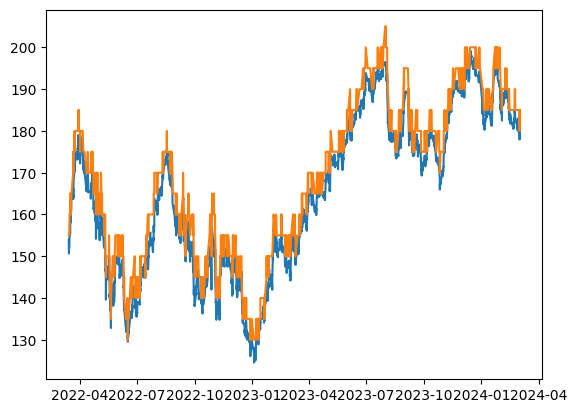

In [29]:
plt.plot(new_stock_data["s_c"])
plt.plot(df_strike_df["c_1"])

Get percentage change differences to make the strike prices relative to the stock price.

### Analytics Calculations on S

In [125]:
df_strike_df = load_pickle("df_strike_df.pkl")
Y_hat_df = load_pickle("Y_hat_df.pkl")
df_strike_df = pd.concat([df_strike_df, Y_hat_df], axis=1).ffill()

df_strike_df["dist_ab"] = (10 - (df_strike_df["s_c"] % 10)) % 10
df_strike_df["dist_bel"] = (df_strike_df["s_c"] % 10)


df_strike_df["7_ma"] = df_strike_df["s_c"].rolling(7).mean()
df_strike_df["30_ma"] = df_strike_df["s_c"].rolling(30).mean()
df_strike_df["100_ma"] = df_strike_df["s_c"].rolling(100).mean()

for i in range(1,8):
    df_strike_df["7_ma"].iloc[i] = df_strike_df["s_c"].rolling(i).mean().iloc[i]

for i in range(1,31):
    df_strike_df["30_ma"].iloc[i] = df_strike_df["s_c"].rolling(i).mean().iloc[i]

for i in range(1,101):
    df_strike_df["100_ma"].iloc[i] = df_strike_df["s_c"].rolling(i).mean().iloc[i]

df_strike_df["7_ma_dist"] = df_strike_df["s_c"] - df_strike_df["7_ma"]
df_strike_df["30_ma_dist"] = df_strike_df["s_c"] - df_strike_df["30_ma"]
df_strike_df["100_ma_dist"] = df_strike_df["s_c"] - df_strike_df["100_ma"]

for pc in ["c", "p"]:
    for i in range(0,3):
        df_strike_df[f"pct_{pc}{i}"] = (df_strike_df[f"{pc}_{i}"] - df_strike_df["s_c"])/(df_strike_df["s_c"])

times = [1, 10, 50]

for t in times:
    df_strike_df[f"pct_s_{t}"] = df_strike_df["s_c"].pct_change(t)
    for i in range(1,t+1):
        df_strike_df[f"pct_s_{t}"].iloc[i] = df_strike_df["s_c"].iloc[:i+1].pct_change(i)[-1]
    
df_strike_df.fillna(0, inplace=True)

Dictionary imported successfully.
Dictionary imported successfully.


In [126]:
s_data = {}

episode_list = df_strike_df["expiry"].sort_index().drop_duplicates()

for i, ep in enumerate(episode_list):
    data = df_strike_df[df_strike_df["expiry"] == ep]
    s_data.update({i: {"start_date": str(data.index.min().date()), "exp_date": ep, "data": data}})

In [130]:
s_data[0]["data"].columns

Index(['s_v', 's_vw', 's_o', 's_c', 's_h', 's_l', 's_n', 's_t_until_exp',
       'c_0', 'c_1', 'c_2', 'p_0', 'p_1', 'p_2', 'expiry', 'Y_hat', 'dist_ab',
       'dist_bel', '7_ma', '30_ma', '100_ma', '7_ma_dist', '30_ma_dist',
       '100_ma_dist', 'pct_c0', 'pct_c1', 'pct_c2', 'pct_p0', 'pct_p1',
       'pct_p2', 'pct_s_1', 'pct_s_10', 'pct_s_50'],
      dtype='object')

## Predictive Analytics

In [80]:
from keras.models import Sequential
from math import sqrt, floor
import tensorflow as tf
import pandas as pd
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy.stats import pearsonr
from threading import Thread
from queue import Queue
import warnings
warnings.filterwarnings('ignore')
import os

2024-03-17 23:11:58.197710: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-17 23:11:59.486869: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-17 23:12:02.545830: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-17 23:12:06.417416: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### LSTM Functions

In [82]:
# Input data (X) to be provided with a specific array structure in the form of [samples, time steps, features].
def ts_generator(data, win_length):
    # Note the position of the Y value (1st col).
    X_data = [data[i:i+win_length, 1:] for i in range(data.shape[0]-win_length)]
    X_data = np.stack(X_data, axis=0)
    Y_data = np.array([data[win_length+i, 0] for i in range(0, data.shape[0]-win_length)])
    Y_data = Y_data.reshape(Y_data.shape[0], 1)
    return X_data, Y_data

def gen_data(data, win_length, test_size):
    # add sliding window here.
    test_data = data[-int(test_size * len(data)):]
    train_data = data[:int((1-test_size) * len(data))]
    scaler = StandardScaler()
    
    if test_size != 0:
        test_data_scaled = scaler.fit_transform(test_data)
        X_test, Y_test = ts_generator(test_data_scaled, win_length)
    else:
        X_test, Y_test = None, None

    scaler.fit(train_data)
    train_data_scaled = scaler.transform(train_data)
    scaler.fit(train_data.to_numpy()[:,0].reshape(-1, 1))
    
    X_train, Y_train = ts_generator(train_data_scaled, win_length)

    return X_train, Y_train, X_test, Y_test, scaler

def run_LSTM(X_train, Y_train, win_length, num_features, arch, epochs):
    model_lstm = Sequential()

    model_lstm.add(LSTM(arch[0], activation="relu", input_shape=(win_length, num_features), return_sequences=True))
    for i in range(1, len(arch)-1):
        model_lstm.add(LSTM(arch[i], activation="relu", return_sequences=True))
    model_lstm.add(LSTM(arch[-1], activation="relu", return_sequences=False))
    model_lstm.add(Dense(1))

    model_lstm.compile(optimizer="adam", loss="mse")
    #model_lstm.summary()

    res = model_lstm.fit(X_train, Y_train, epochs=epochs,
                                shuffle=False, verbose=0)
    return model_lstm

### Validation

In [24]:
df_strike_df = load_pickle("df_strike_df.pkl")
data = df_strike_df[["s_c", "s_v", "s_vw", "s_o", "s_h", "s_l", "s_n"]]
data = data[-500:]
results_arr = []

architectures = [[256, 128, 64, 32, 16], [32, 64, 16, 8], [64, 32, 16]]
epochs = [120, 100, 80, 50]
win_lengths = np.arange(3,10)
num_features = 6
test_size = 0.1

for arch in architectures:
    for epoch in epochs:
        for win_length in win_lengths:
            X_train, Y_train, X_test, Y_test, scaler = gen_data(data, win_length, test_size)
            model_lstm = run_LSTM(X_train, Y_train, win_length, num_features, arch, epoch)
            
            Y_hat_scaled = model_lstm.predict(X_test)
            Y_hat = scaler.inverse_transform(Y_hat_scaled)
            test_index = int((1-test_size)*len(data)+win_length)
            Y_hat = pd.DataFrame(Y_hat, index=data.index[test_index:])
            RMSE = sqrt(mean_squared_error(data["s_c"][test_index:], Y_hat))
            MAPE = mean_absolute_percentage_error(data["s_c"][test_index:], Y_hat)
            results_arr.append([arch, epoch, win_length, RMSE, MAPE])

#plt.plot(Y_hat)
#plt.plot(data[test_index:]["s_c"])

Dictionary imported successfully.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step


In [ ]:
results_arr = load_pickle("results_arr.pkl")
results_arr = pd.DataFrame(results_arr, columns=["Architecture", "Epochs", "Window Length", "RMSE", "MAPE"])
results_arr = results_arr.astype({"Architecture": str})

#for arch in results_arr["Architecture"].unique():
#    plt.plot(np.arange(28), results_arr[results_arr["Architecture"] == arch]["MAPE"])

results_arr.groupby(["Architecture", "Epochs"]).mean()
arch = "[64, 32, 16]"
results_arr[results_arr["Architecture"] == arch].sort_values(by="MAPE")

### Predicting Across Entire Dataset

In [92]:
data = load_pickle("df_strike_df.pkl")[["s_c", "s_v", "s_vw", "s_o", "s_h", "s_l", "s_n"]]

# model = [64, 32, 16] 100 5
arch = [64, 32, 16] 
epoch = 100 
win_length = 5
num_features = 6
test_size = 0.0
retrain_intervals = [i for i in range(0, len(df_strike_df), 600)][1:2]
Y_hat_df = pd.DataFrame()

for i, interval in enumerate(retrain_intervals):
    if i == 0:
        data_interval_train = data[-interval:]
        data_interval_test = data[:interval]
        test_index = data[win_length:interval].index
    else:
        data_interval_train = data[:interval]
        data_interval_test = data[interval:interval+600]
        test_index = data[interval + win_length:interval+600].index

    X_train, Y_train, X_test, Y_test, scaler = gen_data(data_interval_train, win_length, test_size)
    model_lstm = run_LSTM(X_train, Y_train, win_length, num_features, arch, epoch)

    X_test, _, _, _, _ = gen_data(data_interval_test, win_length, test_size=0)
    
    Y_hat_scaled = model_lstm.predict(X_test)
    Y_hat = scaler.inverse_transform(Y_hat_scaled)
    Y_hat_temp = pd.DataFrame(Y_hat, columns="Y_hat", index=test_index)
    Y_hat_df = pd.concat([Y_hat_df, Y_hat_temp])

Dictionary imported successfully.


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


# Final Data Analysis

In [8]:
c_data = load_pickle("call_data_dict_v2.pkl")
dates = []

for key in list(c_data.keys()):
    dates.append(c_data[key]["end_date"])

dates = pd.to_datetime(list(set(dates))).sort_values()

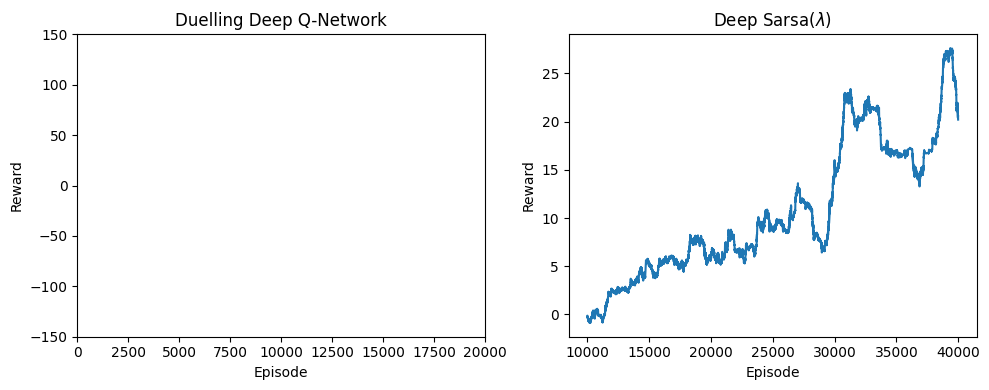

In [4]:
# Training results.
asset_hist = [load_pickle(f"Training Results/asset_hist_{i}.pkl") for i in range(2_000, 40_000, 2_000)]
port_hist = [load_pickle(f"Training Results/port_val_hist_{i}.pkl") for i in range(2_000, 40_000, 2_000)]
rewards = load_pickle("Training Results/reward_arr.pkl")


fig, axes = plt.subplots(1,2, figsize=(10,4), tight_layout=True)
axes[1].plot(pd.Series(rewards).rolling(10_000).mean())
[axes[i].set_ylabel("Reward") for i in [0,1]]
[axes[i].set_xlabel("Episode") for i in [0,1]]
axes[0].set_title("Duelling Deep Q-Network")
axes[1].set_title("Deep Sarsa($\lambda$)")
axes[0].set_xlim(0,20000)
axes[0].set_ylim(-150,150)
plt.savefig("training_res.png", dpi=140)

In [19]:
final_rets[21:].std()

110.3972659308183

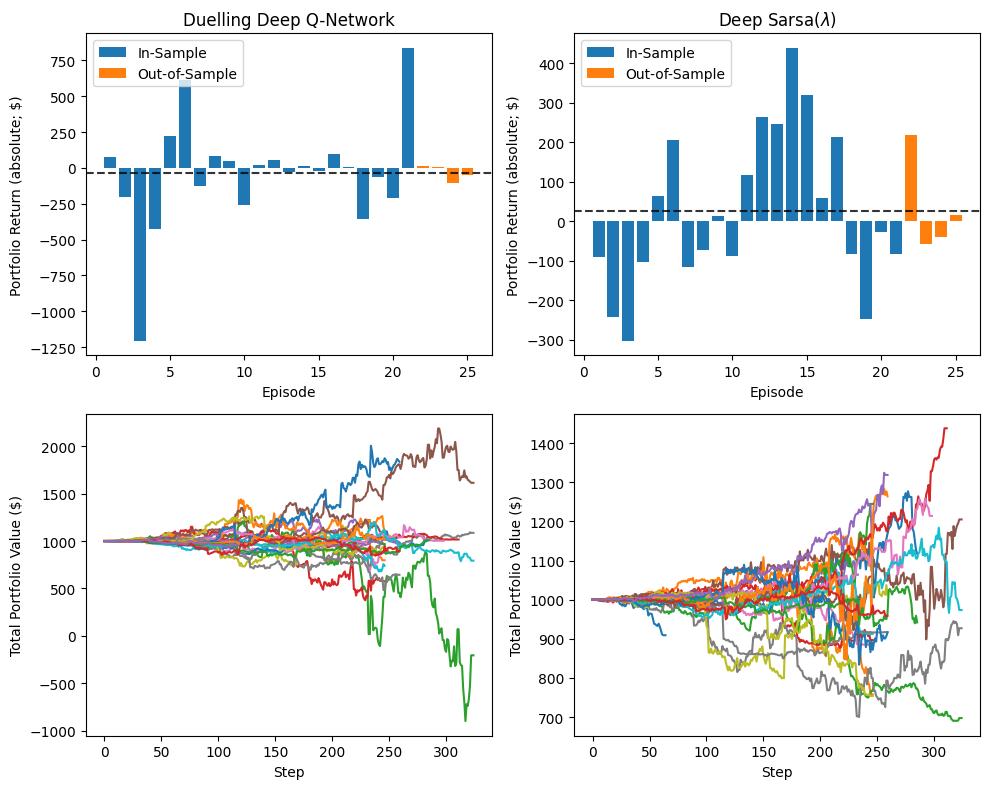

In [30]:
# Results in and out of sample.
port_vals = [load_pickle(f"Summary Data/port_val_hist_{i}.pkl") for i in range(25)]
eps_rets = [load_pickle(f"Summary Data/episode_rets{i}.pkl") for i in range(25)]
actions = [load_pickle(f"Summary Data/episode_actions_{i}.pkl") for i in range(25)]

port_vals_dq = [load_pickle(f"Test Data DQN/port_val_hist_{i}.pkl") for i in range(25)]
eps_rets_dq = [load_pickle(f"Test Data DQN/episode_rets{i}.pkl") for i in range(25)]

fig, axes = plt.subplots(2,2, figsize=(10,8), tight_layout=True)
final_rets = np.zeros(25)
final_rets_dq = np.zeros(25)
stds = np.zeros(25)
sharpe = np.zeros(25)

for i, arr in enumerate(port_vals):
    final_rets[i] = arr[-1]-1000
    final_rets_dq[i] = port_vals_dq[i][-1]-1000
    sharpe[i] = (eps_rets[i].mean()-0.02)/eps_rets[i].std()
    stds[i] = eps_rets[i].std()
    axes[1,1].plot(arr)
    axes[1,0].plot(port_vals_dq[i])

axes[0,1].bar(range(1,22), final_rets[:21], label="In-Sample")
axes[0,1].bar(range(22,26), final_rets[21:], label="Out-of-Sample")
axes[0,1].legend(loc="upper left")
axes[0,1].axhline(final_rets.mean(), color="black", linestyle="dashed", alpha=0.8)
axes[1,0].set_xlabel("Step")
axes[1,0].set_ylabel("Total Portfolio Value ($)")
axes[0,0].set_xlabel("Episode")
axes[0,0].set_ylabel("Portfolio Return (absolute; $)")

axes[0,0].bar(range(1,22), final_rets_dq[:21], label="In-Sample")
axes[0,0].bar(range(22,26), final_rets_dq[21:], label="Out-of-Sample")
axes[0,0].legend(loc="upper left")
axes[0,0].axhline(final_rets_dq.mean(), color="black", linestyle="dashed", alpha=0.8)
axes[1,1].set_xlabel("Step")
axes[1,1].set_ylabel("Total Portfolio Value ($)")
axes[0,1].set_xlabel("Episode")
axes[0,1].set_ylabel("Portfolio Return (absolute; $)")

axes[0,0].set_title("Duelling Deep Q-Network")
axes[0,1].set_title("Deep Sarsa($\lambda$)")
plt.savefig("general_stats.png", dpi=190)

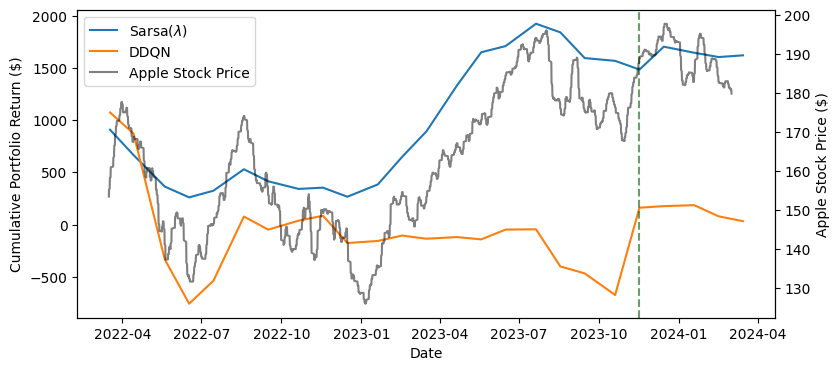

In [72]:
# Null Models.
df_strike_df = load_pickle("df_strike_df.pkl")
total_hist_dq = (final_rets_dq.cumsum() + 1000)
total_hist = (final_rets.cumsum() + 1000)

fig, axes = plt.subplots(1, figsize=(9,4))
line1, = axes.plot(dates, total_hist, label='Sarsa($\lambda$)')
line2, = axes.plot(dates, total_hist_dq, label='DDQN')
axestwn = axes.twinx()
line3, = axestwn.plot(df_strike_df["s_c"].rolling(30).mean(), color="black", alpha=0.5, label='Apple Stock Price')
axestwn.set_ylabel("Apple Stock Price ($)")
axes.set_xlabel("Date")
axes.set_ylabel("Cumulative Portfolio Return ($)")

# Combine all the lines and labels for the legend
lines = [line1, line2, line3]
labels = [line.get_label() for line in lines]

# Create the legend
axes.legend(lines, labels, loc='upper left')
axes.axvline(dates[20], color="darkgreen", alpha=0.6, linestyle="dashed")

plt.savefig("final_backtest_comp.png", dpi=200)

# Options Payoff Graph

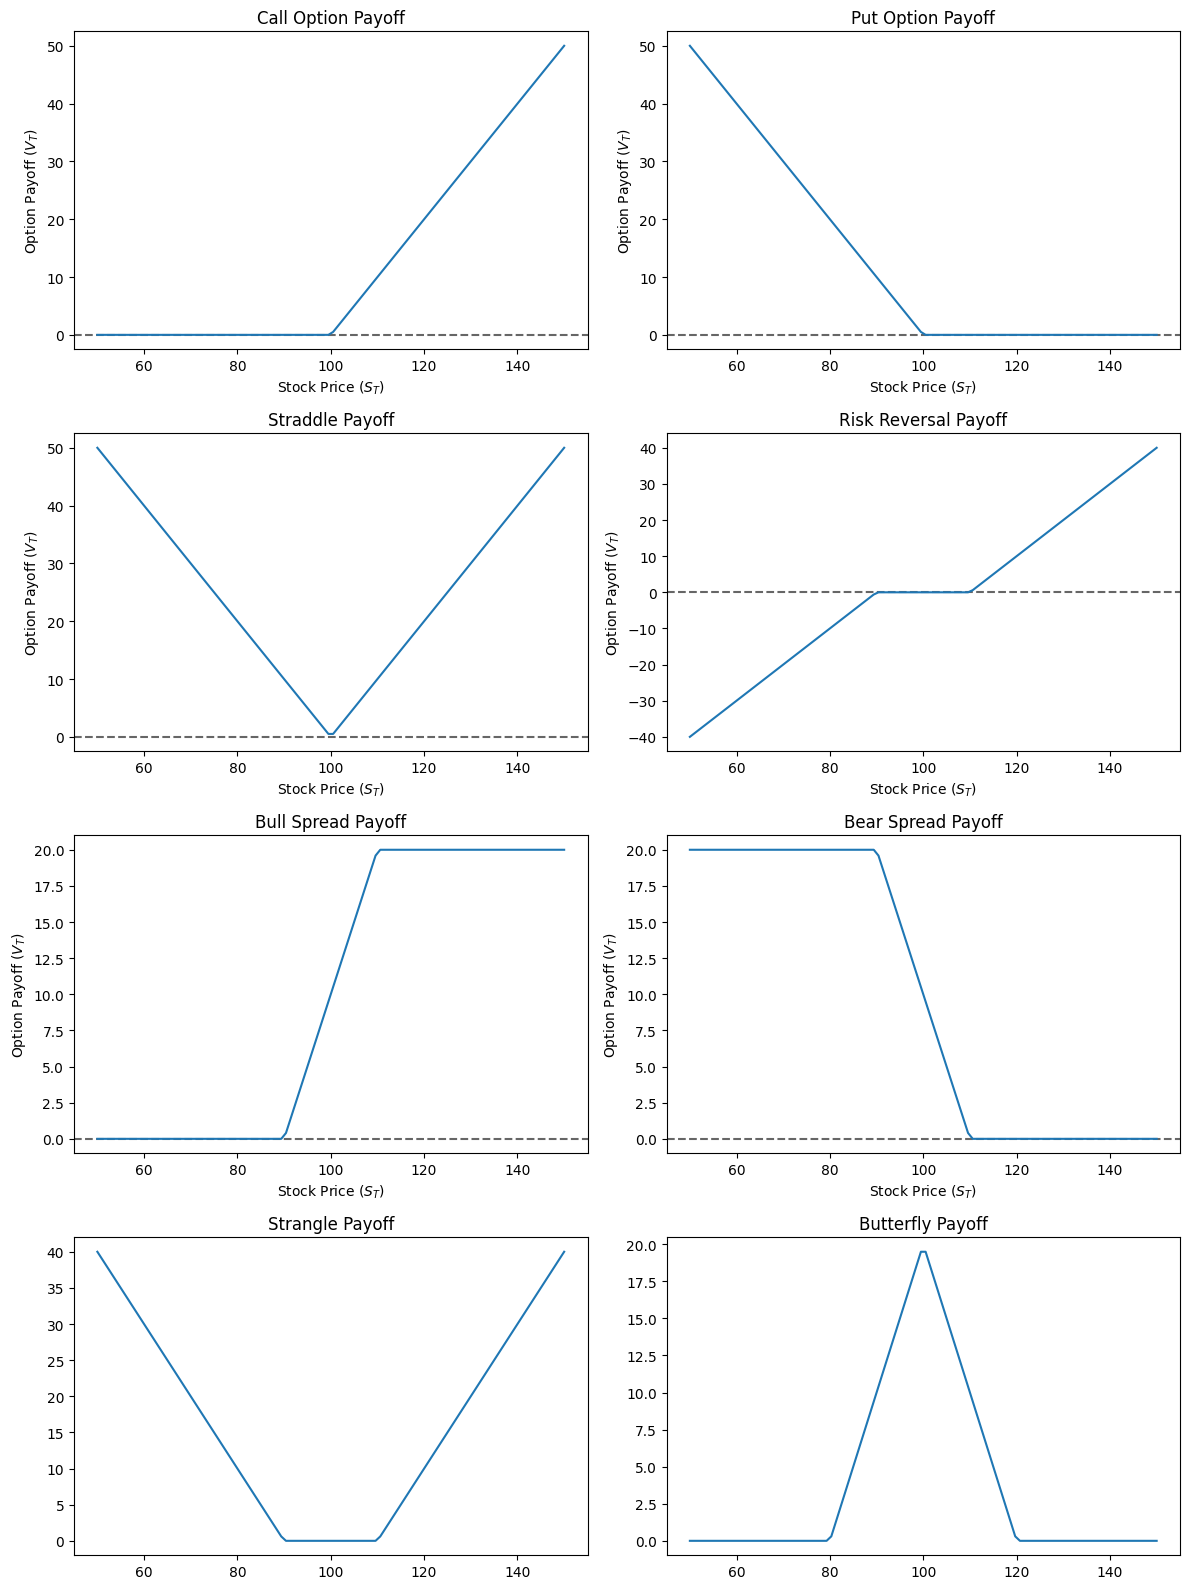

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Define the range of underlying asset prices
s = np.linspace(50, 150, 100)

# Define functions for various options strategies
def call_payoff(s, strike):
    return np.maximum(s - strike, 0)

def put_payoff(s, strike):
    return np.maximum(strike - s, 0)

def straddle_payoff(s, strike):
    return np.abs(s - strike)

def risk_reversal_payoff(s, strike_long, strike_short):
    return call_payoff(s, strike_long) - put_payoff(s, strike_short)

def bull_spread_payoff(s, strike_low, strike_high):
    return call_payoff(s, strike_low) - call_payoff(s, strike_high)

def bear_spread_payoff(s, strike_low, strike_high):
    return put_payoff(s, strike_high) - put_payoff(s, strike_low)

def strangle_payoff(s, strike_low, strike_high):
    return put_payoff(s, strike_low) + call_payoff(s, strike_high)

def butterfly_payoff(s, strike_low, strike_mid, strike_high):
    return call_payoff(s, strike_low) - 2 * call_payoff(s, strike_mid) + call_payoff(s, strike_high)

# Create subplots for each options strategy
fig, axes = plt.subplots(4, 2, tight_layout=True, figsize=(12, 16))
for col in range(2):
    for row in range(3):
        axes[row,col].set_xlabel("Stock Price ($S_T$)")
        axes[row,col].set_ylabel("Option Payoff ($V_T$)")
        axes[row,col].axhline(0, color="black", alpha=0.6, linestyle="dashed")

# Plot payoffs for each strategy
axes[0, 0].plot(s, call_payoff(s, 100))
axes[0, 0].set_title('Call Option Payoff')
axes[0, 1].plot(s, put_payoff(s, 100))
axes[0, 1].set_title('Put Option Payoff')
axes[1, 0].plot(s, straddle_payoff(s, 100))
axes[1, 0].set_title('Straddle Payoff')
axes[1, 1].plot(s, risk_reversal_payoff(s, 110, 90))
axes[1, 1].set_title('Risk Reversal Payoff')
axes[2, 0].plot(s, bull_spread_payoff(s, 90, 110))
axes[2, 0].set_title('Bull Spread Payoff')
axes[2, 1].plot(s, bear_spread_payoff(s, 90, 110))
axes[2, 1].set_title('Bear Spread Payoff')
axes[3, 0].plot(s, strangle_payoff(s, 90, 110))
axes[3, 0].set_title('Strangle Payoff')
axes[3, 1].plot(s, butterfly_payoff(s, 80, 100, 120))
axes[3, 1].set_title('Butterfly Payoff')

plt.savefig("option_payoffs.png", dpi=200)

In [5]:
call

50.0